## HubMap Training Notebook

### Setup

In [1]:
import os
import gc
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

### Config

In [2]:
class CFG:
    LR = 1e-3
    EPOCHS = 100
    BATCH_SIZE = 6
    N_TRAIN = 6500 # Take first N_TRAIN images for training, rest for validation
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import os 

train_dir = "/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train"
# list all files in train_dir
train_files = os.listdir(train_dir)
train_files = [os.path.join(train_dir, f) for f in train_files]

print(len(train_files)), train_files[:10]

7033


(None,
 ['/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train/337e17d4e5cf.tif',
  '/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train/1ffaa49d2903.tif',
  '/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train/fa207406c405.tif',
  '/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train/eafdccd83fe3.tif',
  '/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train/d988061d3b4d.tif',
  '/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train/a761bffc2273.tif',
  '/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train/1a481f256def.tif',
  '/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train/da254bd94671.tif',
  '/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train/a0c0e4d2953d.tif',
  '/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train/f356e2e906c8.tif'])

### Dataloaders

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
from PIL import Image
from skimage.draw import polygon
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip, BboxParams



class HubmapDataset(Dataset):
        
    def __init__(self, n_train=6500, mode='train'):
        
        self.images = train_files
        
        labels_file="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl" 
        with open(labels_file, 'r') as json_file:
            self.json_labels = [json.loads(line) for line in json_file]
        
        self.json_labels_val = self.json_labels[1400:]
        
        self.json_labels_val = [ann['id'] for ann in self.json_labels_val]
        
        print("Performing train/val split...")
        if mode == 'train':
            # self.image_paths = self.images[:n_train]
            self.image_paths = [f for f in self.images if f.split("/")[-1].replace('.tif', '') not in self.json_labels_val]
        else:
            # self.image_paths = self.images[n_train:]
            self.image_paths = [f for f in self.images if f.split("/")[-1].replace('.tif', '') in self.json_labels_val]
        print("Done!")
        
        
        if mode == 'train':
            initial_augm = [
            
                
                A.HorizontalFlip(p=0.25),
                A.VerticalFlip(p=0.25),
                A.Transpose(p=0.25),
                A.GridDistortion(p=0.25),
                A.RandomSizedCrop(min_max_height=(int(512 * 0.8), int(512 * 0.9)),
                                    height=512, width=512, p=0.25),
                # A.CoarseDropout(max_holes=1, max_width=int(512 * 0.05), max_height=int(512 * 0.05), mask_fill_value=0, p=0.2),
                
                
                A.CLAHE(p=0.2),
                A.RandomBrightnessContrast(p=0.2),    
                A.RandomGamma(p=0.2),
                
                A.OneOf([
                        A.GaussNoise(var_limit=[10, 50]),
                        A.GaussianBlur(),
                        A.MotionBlur(),
                        ], p=0.1),
                A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05), p=0.2),
                
            ]
        else:
            initial_augm = []
        
        self.aug_list = initial_augm + [
                A.Resize(512, 512),
                A.Normalize(
                    mean= [0, 0, 0],
                    std= [1, 1, 1],
                    max_pixel_value = 255
                ),
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.aug_list)

    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
                    
        # print min max and type of image
        # print(np.array(image).min(), np.array(image).max(), np.array(image).dtype) -> 0 255 uint8
        
        image = np.array(image)

        augmented = self.augmentations(image=image)
        
        image = augmented['image']        
        
        
        # calculate mean and std per channel
        mean = torch.mean(image, dim=[1,2])
        std = torch.std(image, dim=[1,2])
        image = (image - mean[:, None, None]) / std[:, None, None]
        
        # add noise with std=1
        std = 0.2
        noise = std * torch.randn((1, 512, 512)) 
        
        
        image = image + noise

        
        return image, noise


In [5]:
train_dataset = HubmapDataset(n_train=CFG.N_TRAIN,
                              mode='train')

val_dataset = HubmapDataset(  n_train=CFG.N_TRAIN,
                              mode='val')

Performing train/val split...
Done!
Performing train/val split...
Done!


In [6]:
print(len(train_dataset), len(val_dataset))

6800 233


In [7]:
indx = np.random.randint(0, len(train_dataset))
image, mask = train_dataset[indx]

print(image.min(), image.max(), image.std(), image.mean(), image.shape, image.dtype)

tensor(-3.8395) tensor(3.1582) tensor(1.0203) tensor(-2.6269e-05) torch.Size([3, 512, 512]) torch.float32


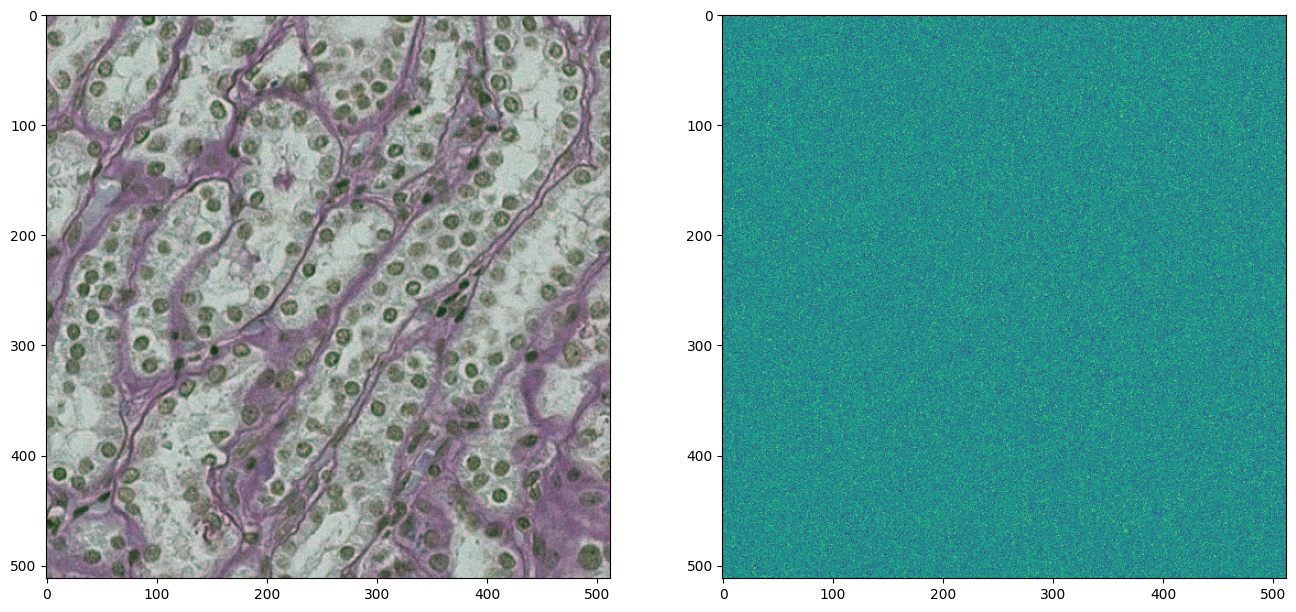

In [8]:

# visualize the data

indx = np.random.randint(0, len(train_dataset))
image, mask = train_dataset[indx]


# inverse normalize
image += image.min().abs()
image /= image.max()

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0))


In [9]:
n_train = len(train_dataset)
n_val = len(val_dataset)


dataloader_train = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, num_workers=1,
                              shuffle=True, pin_memory=False, drop_last=True)

dataloader_valid = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, num_workers=1,
                              shuffle=False, pin_memory=False, drop_last=False)


In [10]:
# get one batch from dataloader_train

for batch in dataloader_train:
    images, masks = batch
    break

# Competition metric

In [11]:
pass

# Model

In [12]:
from transformers import SegformerForSemanticSegmentation
import torch

class Segformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.seg_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         num_labels=1,
                                                         ignore_mismatched_sizes=True,
                                                         num_channels=3)
        self.up = nn.Upsample(scale_factor=4, mode="bilinear")
        
    def forward(self, x):
        x = self.seg_model(x).logits
        x = self.up(x)
        return x



model = Segformer().to(CFG.device)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.lin

In [13]:
x = torch.randn(1, 3, 512, 512).to(CFG.device)
with torch.no_grad():
    out = model(x)
out.shape

torch.Size([1, 1, 512, 512])

# Criterion

In [14]:


def criterion(y_pred, y_true):
    
    # Root Mean Squared Error
    loss = F.mse_loss(y_pred, y_true)
    
    return loss

In [15]:
# Set AdamW optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LR)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 
                                              start_factor=0.01,
                                              end_factor=1,
                                              total_iters=10)


# Training

In [16]:
best_fbeta_ = 0.0


for epoch in range(1, CFG.EPOCHS+1):
    model.train()
    
    cur_lr = optimizer.param_groups[0]['lr']
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    
    mloss_train = 0.

    for i, (images, masks) in pbar_train:
        images, masks = images.to(CFG.device), masks.to(CFG.device)
        
        
        optimizer.zero_grad()
        pred_masks = model(images)
        loss = criterion(pred_masks, masks)
        loss.backward()
        mloss_train += loss.detach().item()
        optimizer.step()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
        # if i > 10:
        #     break
    
    
    out = {}
    out['epoch'] = epoch
    out['loss_train'] = mloss_train / len(dataloader_train)
    
    model.eval()
    
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    
    mloss_val = 0.
    
    
    
    for i, (images, masks) in pbar_val:
        images, masks = images.to(CFG.device), masks.to(CFG.device)
        
        with torch.no_grad():
            pred_masks = model(images)
            mloss_val += criterion(pred_masks, masks).item()

        
        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    
    
    scheduler.step()
    
    out['loss_val'] = mloss_val / len(dataloader_valid)
    
    
    # save out to csv. Rewrite every epoch
    if epoch == 1:
        df = pd.DataFrame(out, index=[0])
        df.to_csv("./segformer.csv", index=False)
    else:
        df = pd.DataFrame(out, index=[0])
        df_old = pd.read_csv("./segformer.csv")
        df = pd.concat([df_old, df], axis=0)
        df.to_csv("./segformer.csv", index=False)
    
    
    
    torch.save(model.state_dict(), f"./ckpts/segformer_epoch_{epoch}.pt")
    

Epoch 1/100  Mem : 16.7GB       1e-05  Loss: 0.1486:   1%|          | 8/1133 [00:02<05:46,  3.25it/s]

Epoch 1/100  Mem : 16.7GB       1e-05  Loss: 0.1390:   1%|          | 11/1133 [00:03<06:47,  2.75it/s]
Val Loss: 0.0446: 100%|██████████| 39/39 [00:03<00:00, 12.68it/s]
Epoch 2/100  Mem : 16.7GB  0.00010899999999999999  Loss: 0.1007:   1%|          | 8/1133 [00:02<06:34,  2.85it/s]


KeyboardInterrupt: 

: 